In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import time
import pandas as pd
from scipy.stats import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
plt.rcParams["figure.figsize"]=(16,9)

Disclamer: near the end of the code there is a test checking if inverting A matrix before making the loop speeds up the computations (those computations does take a while)

In [2]:
#choose scheme from EE, IE and CN
Scheme='CN'
#choose if one want to use sparse matrices, in order to get better efficiency all matrices will be transformed into sparse
use_sparse=False
#choose True if one wants to compute errors using the Black-Scholes formula, False if not
BS_error=False

In [3]:
#the things below are same for all schemes so I just code them here
K=100
S_min=0
S_max=200
T=1
sigma=0.2
r=0.1
#price at which the errors and convergences will be evaluated 
s_val=80
def phi(S,I):
    return np.maximum(K-S,0.).reshape(I,1)
def vL(t,):
    return K*np.exp(-r*t)-S_min
def vR(t):
    return 0
def interpolated_value(s_bar,h):
    i=int(s_bar/h)-1
    return float((S[i+1]-s_bar)*U[i]/h+(s_bar-S[i])*U[i+1]/h)
def interpolated_value(s_bar,h,U,S):
    i=int(s_bar/h)-1
    return float((S[i+1]-s_bar)*U[i]/h+(s_bar-S[i])*U[i+1]/h)
#the below function gives price computed by the Black Scholes formula
def BS_formula_put(S_0,K,r,sigma,T):
    d_1=(np.log(S_0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d_2=d_1-sigma*np.sqrt(T)
    return -S_0*norm.cdf(-d_1)+K*np.exp(-r*T)*norm.cdf(-d_2)

def make_output_table (table,BS_error,s_val,K,r,sigma,T):
    if BS_error:
        table["error"]=abs(table['U(%.2f)' %s_val]-BS_formula_put(s_val,K,r,sigma,T))
    else:
        table["error"]=-table['U(%.2f)' %s_val].diff()
    for i in range(1, len(table)):
        table.loc[i,"error order"]=np.log(table.loc[i-1,"error"]/table.loc[i,"error"])/np.log((table.loc[i,"I"]+1)/(table.loc[i-1,"I"]+1))
    return table

In [4]:
def EE(N,U,A,delta_t,alpha,beta,use_sparse):
    q=np.zeros_like(U)
    if use_sparse:
        U=sparse.csr_matrix(U)
    for n in range(N):
        t=delta_t*n
        q[0]=(-alpha[0]+beta[0])*vL(t)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        if use_sparse:
            q=sparse.csr_matrix(q)
            U=(sparse.eye(I)-delta_t*A) @(U-delta_t*q)
            U=U.reshape(I,1)
        else:
            U=(np.eye(I)-delta_t*A) @(U-delta_t*q)
    #in this case we have to convert the outcome to the numpy array in order to make graphs later on
    if use_sparse:
        return U.toarray()
    else:
        return U

def IE(N,U,A,delta_t,alpha,beta,use_sparse):
    q=np.zeros_like(U)
    if use_sparse:
        U=sparse.csr_matrix(U)
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        if use_sparse:
            q=sparse.csr_matrix(q)
            U=spsolve(sparse.eye(I)+delta_t*A,U-delta_t*q)
            U=U.reshape(I,1)
        else:
            U=lng.solve(np.eye(I)+delta_t*A,U-delta_t*q)
    return U

def CN(N,U,A,delta_t,alpha,beta,use_sparse):
    q=np.zeros_like(U)
    if use_sparse:
        U=sparse.csr_matrix(U)
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        if use_sparse:
            q=sparse.csr_matrix(q)
            U=spsolve(sparse.eye(I)+delta_t*A/2,(np.eye(I)-delta_t*A/2) @(U)-delta_t*q)
            U=U.reshape(I,1)
        else:
            U=lng.solve(np.eye(I)+delta_t*A/2,(np.eye(I)-delta_t*A/2) @(U)-delta_t*q)
    return U

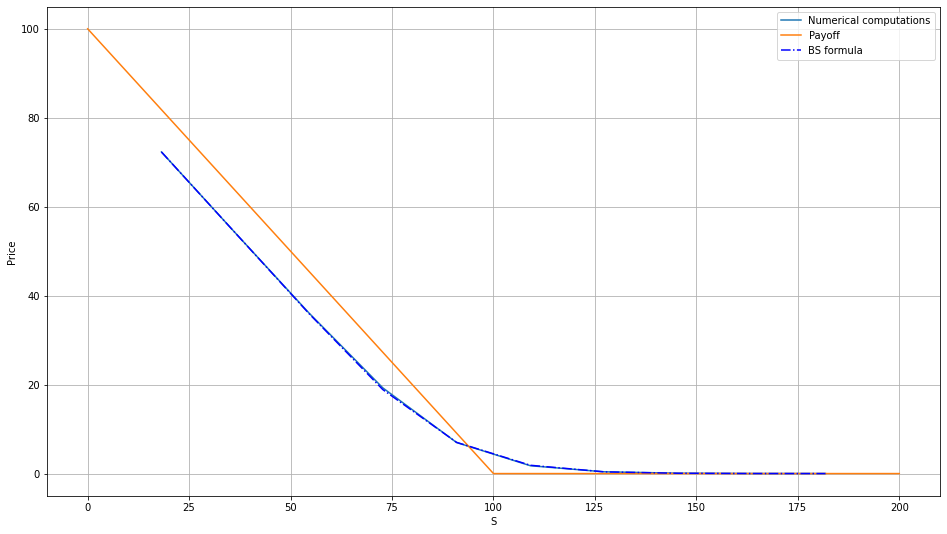

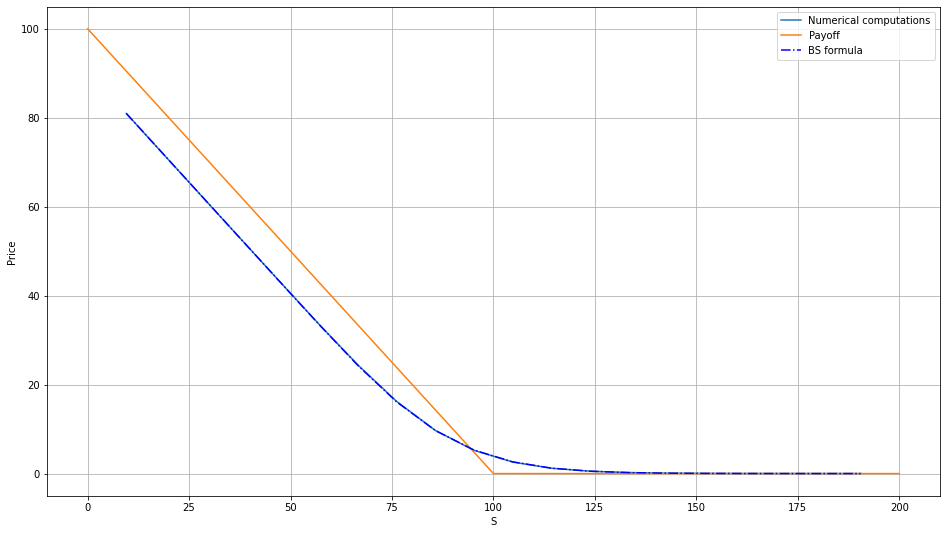

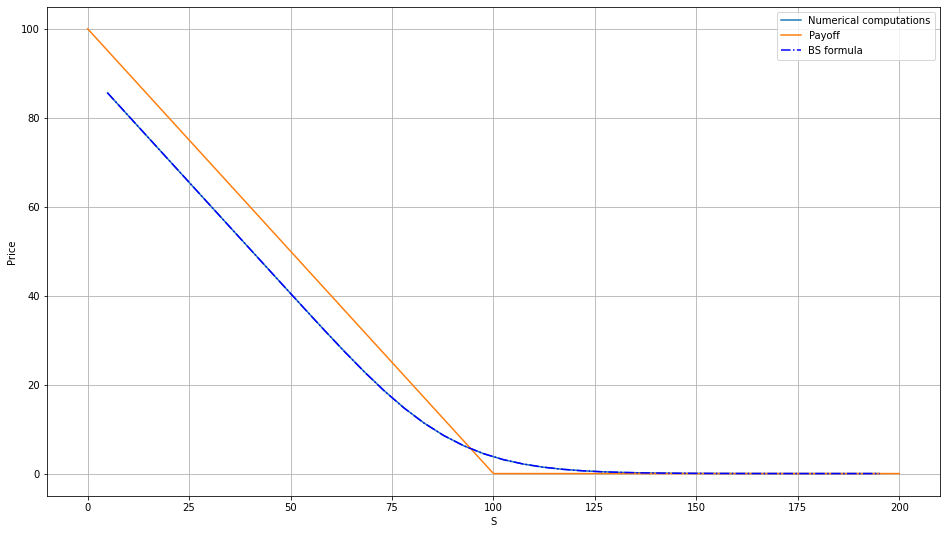

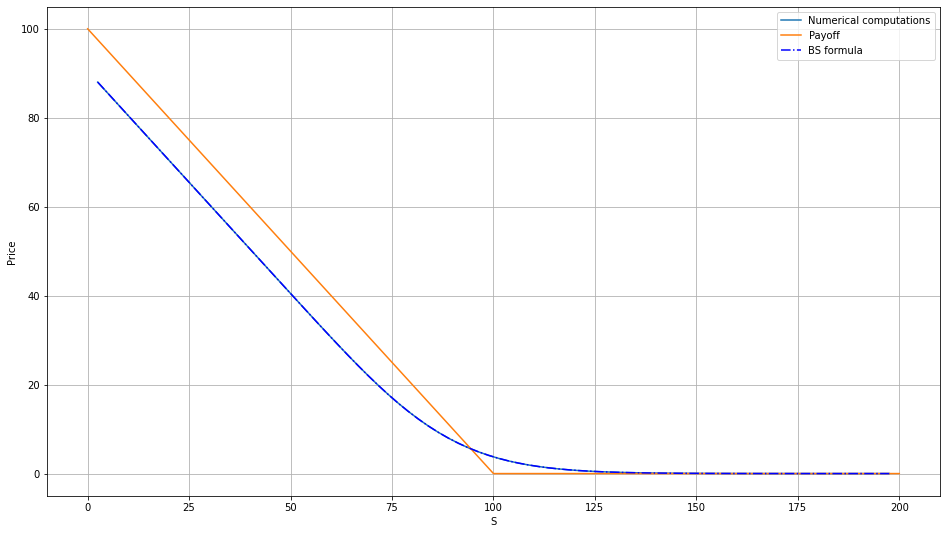

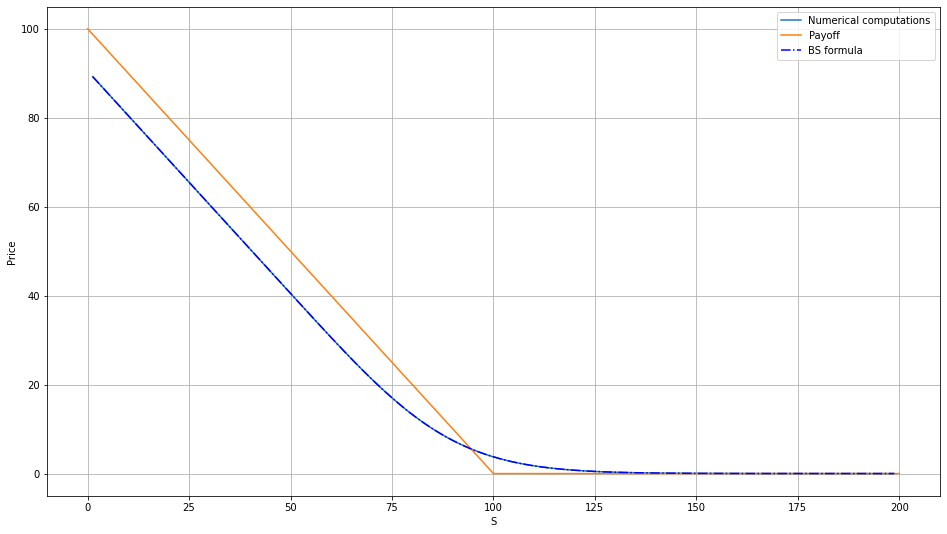

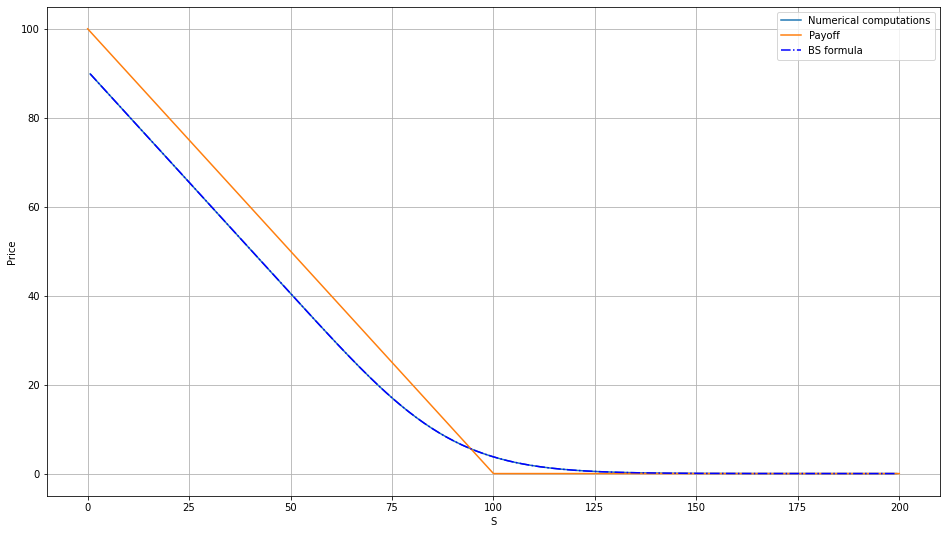

Wall time: 5.79 s


In [5]:
%%time
table_1=[]
for I,N in zip([10,20,40,80,160,320], [10,20,40,80,160,320]):
#for I,N in zip([10,20,40,80,160,320], [10,40,160,640,2540,10240]):
    h=(S_max-S_min)/(I+1)
    delta_t=T/N
    #S=S_min*np.arange(1,I+1)+h*np.arange(1,I+1)
    S=S_min*np.ones(I)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    U=phi(S,I)
    if use_sparse:
        A=sparse.csr_matrix(A)
    
    if (Scheme=='EE'):
        print((delta_t/h**2)*(sigma*S_max)**2)
        U=EE(N,U,A,delta_t,alpha,beta,use_sparse)
    
    if (Scheme=='IE'):
        U=IE(N,U,A,delta_t,alpha,beta,use_sparse)
        
    if (Scheme=='CN'):
        U=CN(N,U,A,delta_t,alpha,beta,use_sparse)    
    
    plt.plot(S,U, label="Numerical computations")
    plt.xlabel("S")
    plt.ylabel("Price")
    plt.legend("Outcome of the computations")
    plt.plot([0,100,200],[100,0,0], label="Payoff")
    plt.plot(S,BS_formula_put(S,K,r,sigma,T), linestyle='dashdot', color="blue", label="BS formula")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

    table_1.append(
        {'I': I,
        'N': N,
        'U(%.2f)' %s_val:  interpolated_value(s_val,h,U,S)})
    
table_1=pd.DataFrame(table_1)

In [6]:
#as the above warning suggest one can use lil_matrix, but I think it won't change too much in this particular case (changing the
#sparsity is not too much of a computational problem I think)

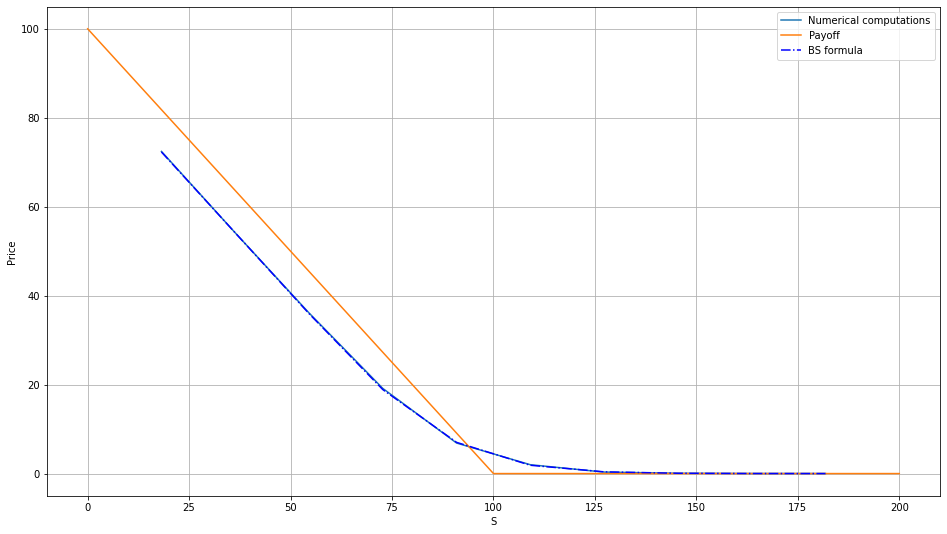

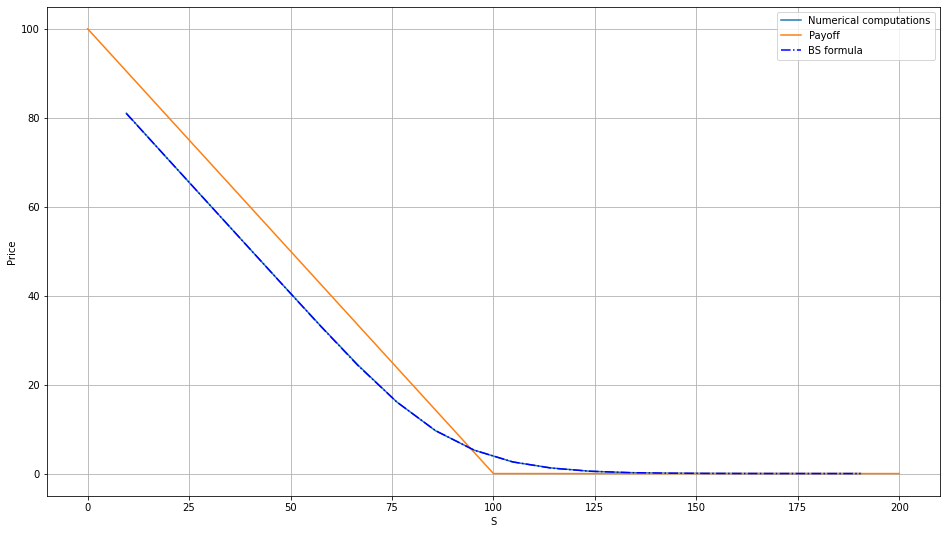

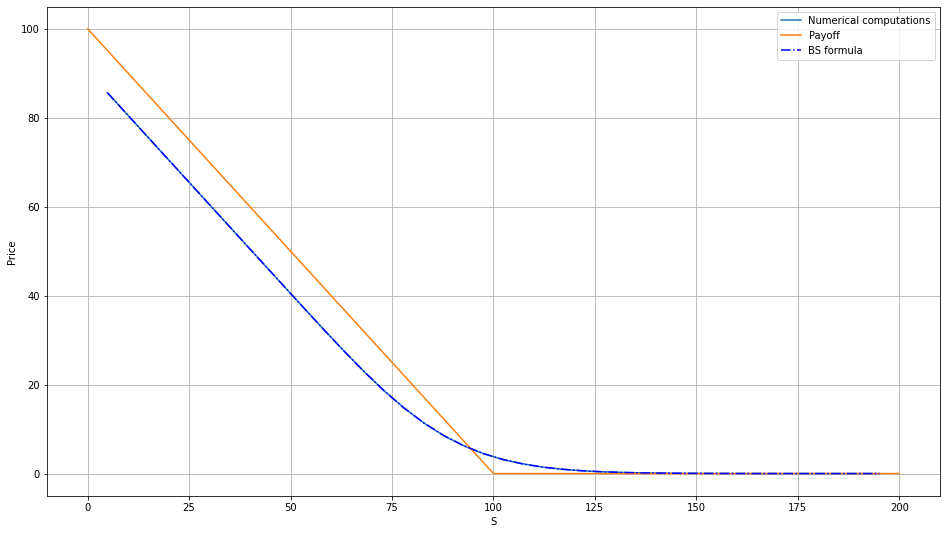

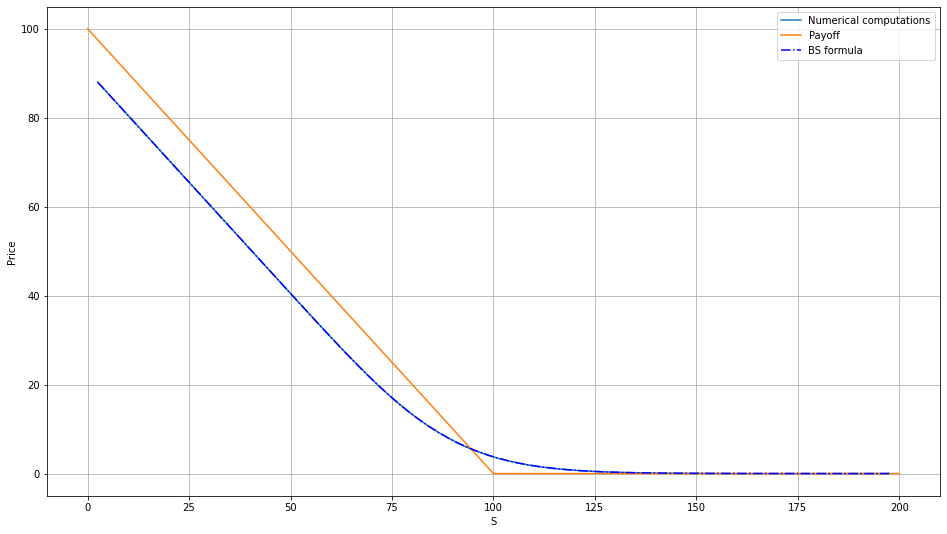

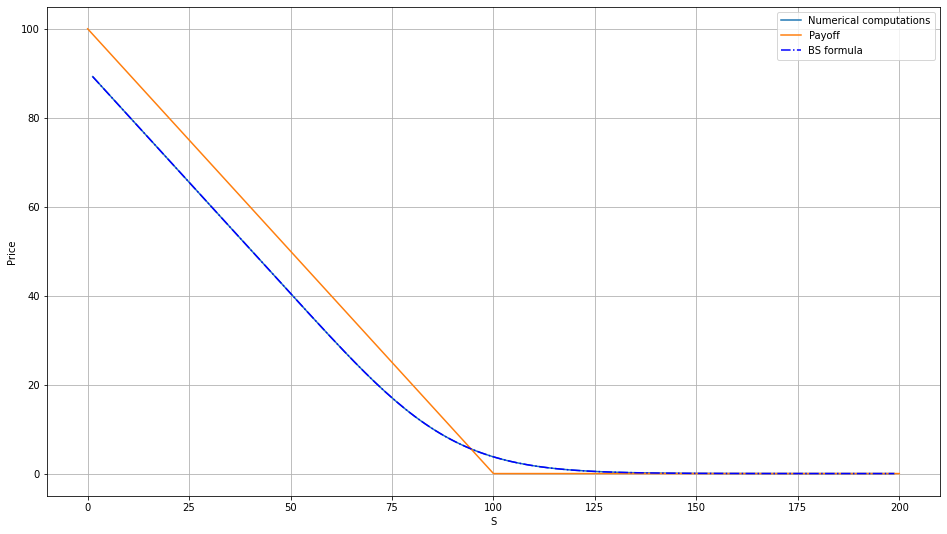

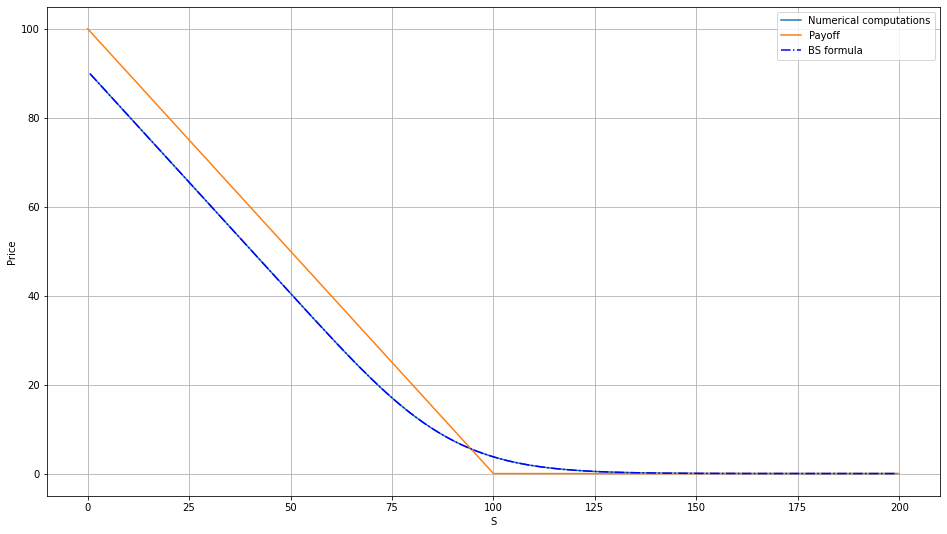

Wall time: 1.46 s


In [7]:
%%time
table_2=[]
if Scheme=='EE':
    iteration_range=zip([10,20,40,80,160,320], [10,40,160,640,2540,10240])
else:
    iteration_range=zip([10,20,40,80,160,320], [1,2,4,8,16,32])
for I,N in iteration_range:
    h=(S_max-S_min)/(I+1)
    delta_t=T/N
    #S=S_min*np.arange(1,I+1)+h*np.arange(1,I+1)
    S=S_min*np.ones(I)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    U=phi(S,I)
    if use_sparse:
        A=sparse.csr_matrix(A)
    
    if (Scheme=='EE'):
        print("the CFL is:",(delta_t/h**2)*(sigma*S_max)**2)
        U=EE(N,U,A,delta_t,alpha,beta,use_sparse)
    
    if (Scheme=='IE'):
        U=IE(N,U,A,delta_t,alpha,beta,use_sparse)
        
    if (Scheme=='CN'):
        U=CN(N,U,A,delta_t,alpha,beta,use_sparse) 
    
    plt.plot(S,U, label="Numerical computations")
    plt.xlabel("S")
    plt.ylabel("Price")
    plt.legend("Outcome of the computations")
    plt.plot([0,100,200],[100,0,0], label="Payoff")
    plt.plot(S,BS_formula_put(S,K,r,sigma,T), linestyle='dashdot', color="blue", label="BS formula")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
    
    table_2.append(
        {'I': I,
        'N': N,
        'U(%.2f)' %s_val:  interpolated_value(s_val,h,U,S)})
    
table_2=pd.DataFrame(table_2)

In [8]:
table_1=make_output_table(table_1,BS_error,s_val,K,r,sigma,T)

In [9]:
table_2=make_output_table(table_2,BS_error,s_val,K,r,sigma,T)

In [10]:
display(table_1)
display(table_2)

,I,N,U(80.00),error,error order
0,10,10,14.353451,NaN,NaN
1,20,20,13.578892,0.774559,NaN
2,40,40,13.353140,0.225752,1.842696
3,80,80,13.293944,0.059195,1.965990
4,160,160,13.278788,0.015156,1.983267
5,320,320,13.274951,0.003837,1.990918


,I,N,U(80.00),error,error order
0,10,1,14.230461,NaN,NaN
1,20,2,13.506181,0.724280,NaN
2,40,4,13.334783,0.171397,2.154094
3,80,8,13.288798,0.045985,1.932315
4,160,16,13.277492,0.011307,2.042244
5,320,32,13.274627,0.002865,1.989305


At the end we can check if inverting A before doing the time increments will improve the computation time. I will still use the sparse matrices since it may make the computations a bit faster.

In [11]:
%%time
table_3=[]
for I,N in zip([500], [5000]):
    h=(S_max-S_min)/(I+1)
    delta_t=T/N
    S=S_min*np.arange(1,I+1)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    U=phi(S,I)
    A=sparse.csr_matrix(A)
    
    U=CN(N,U,A,delta_t,alpha,beta,True) 
    
    table_3.append(
        {'I': I,
        'N': N,
        'U(%.2f)' %s_val:  interpolated_value(s_val,h,U,S)})
    
table_3=pd.DataFrame(table_3)

C:\Users\von dawdop\AppData\Roaming\Python\Python39\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Wall time: 32.6 s


In [12]:
%%time
table_4=[]
for I,N in zip([500], [5000]):
    h=(S_max-S_min)/(I+1)
    delta_t=T/N
    S=S_min*np.arange(1,I+1)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    U=phi(S,I)
    A=sparse.csc_matrix(A)
    B=sparse.linalg.inv(sparse.csc_matrix(sparse.eye(I)+delta_t*A/2))
    
    q=np.zeros_like(U)
    U=sparse.csc_matrix(U)
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        
        q=sparse.csc_matrix(q)
        U=B@((sparse.eye(I)-delta_t*A/2) @(U)-delta_t*q)
        U=U.reshape(I,1)

    U=U.toarray()
    
    table_4.append(
        {'I': I,
        'N': N,
        'U(%.2f)' %s_val:  interpolated_value(s_val,h,U,S)})
    
table_4=pd.DataFrame(table_4)

C:\Users\von dawdop\AppData\Roaming\Python\Python39\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Wall time: 12.6 s


In [13]:
#just to check if the outcome is the same
table_3=make_output_table(table_3,True,s_val,K,r,sigma,T)
table_4=make_output_table(table_4,True,s_val,K,r,sigma,T)

In [14]:
display(table_3)
display(table_4)

,I,N,U(80.00),error
0,500,5000,13.274193,0.00053


,I,N,U(80.00),error
0,500,5000,13.274193,0.00053
